# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Delhi, officially known as the National Capital Territory of Delhi (NCT) is a city and union territory of India containing New Delhi, the capital of India. According to the 2011 Indian census, the population of just the city of Delhi was over 11 million, the second-highest in India after Mumbai. The city is of great historical significance as an important commercial, transport, and cultural hub, as well as the political center of India.

As a resident of Delhi for some time now, it would be an understatement to say that the people of Delhi love street food and enjoy other cuisines. The dearth of food habits among the city’s residents have created a unique style of cooking which has become popular world over, such as Kebab, biryani and tandoori. But, talking about international cuisines, there may be no doubt that Chinese cuisine is the favorite among so many Delhiites.

In this project, we will try to analyze and select the best locations in Delhi to open a new **Chinese restaurant**. Using data science methodology and tools such as data analysis and visualization, we will try to provide the answer to these business questions: 
* What is / are the best locations for opening a Chinese restaurant in Delhi?
* In what neighborhood should we open our restaurant to have better chances of success?

## Data <a name="data"></a>

Based on the definition of our problem, we will need the following data:
* All the neighborhoods of Delhi
* Venue data, particularly related to restaurants. This data will be used to perform further analysis of the neighborhoods.
* Latitude and longitude of the neighborhoods

#### Data sources
Following data sources were needed to extract/generate the required information:
* Geo coordinates of Delhi are obtained using Geopy Nominatim
* Number of restaurants and their type and location in every neighborhood is obtained using the Foursquare API
GET https://api/foursquare/com/v2/venues/explore
* List of all neighborhoods of Delhi is obtained by web scraping the page: https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi

Let us first import the required libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


### Web scraping neighborhood data

In [2]:
pip install BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.


In [3]:
from bs4 import BeautifulSoup

url = requests.get('https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi').text
soup = BeautifulSoup(url,"html.parser")

In [4]:
import re
lis = []
for li in soup.findAll('li'):
    if li.find(href="/wiki/Indira_Gandhi_International_Airport"):
        break
    if li.find(href=re.compile("^/wiki/")):
        lis.append(li)
    if li.find(href=re.compile("^/w/")):
        lis.append(li)
    ## The following place names have no hyperlinks, so we have to add them one by one
    if li.text=='New Usmanpur' or 'Jhandewalan' or 'Kishanganj' or 'Vishwas Nagar' or 'Vivek Vihar':
        lis.append(li)
    if li.text=='Alaknanda' or 'East of Kailash' or 'Hauz Khas Village' or 'Jangpura' or 'Jor Bagh':
        lis.append(li)
    if li.text=='Neeti Bagh' or 'Inderpuri' or 'Mahipalpur' or 'Vikas Nagar':
        lis.append(li)

### Loading and cleaning neighborhood data

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

nbd = []
for i in range(0,len(lis)):
    nbd.append([lis[i].text.strip()])
    
df = pd.DataFrame(nbd)
df.columns = ['Neighborhood']

# cleaning dataframe df
new_df = pd.DataFrame.drop_duplicates(df)
new_df.reset_index(drop = True, inplace = True)
delhi_df = new_df.drop(new_df.index[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]])
delhi_df.reset_index(drop = True, inplace = True)
delhi_df

,Neighborhood
0,Adarsh Nagar
1,Ashok Vihar
2,Begum Pur
3,Karala
4,Model Town
5,Narela
6,Pitam Pura
7,Rohini Sub City
8,Shalimar Bagh
9,Civil Lines


In [6]:
delhi_df['Neighborhood'] = delhi_df.Neighborhood.str.partition('[')[0] # Removes the brackets from Sundar Nagar[1]
delhi_df['Neighborhood'] = delhi_df.Neighborhood.str.partition(';')[0] # Removes the semicolon from Mori Gate; Delhi
delhi_df['Neighborhood'] = delhi_df.Neighborhood.str.partition(',')[0] # Removes the comma from Dabri, New Delhi
delhi_df.reset_index(inplace=True,drop=True)
delhi_df

,Neighborhood
0,Adarsh Nagar
1,Ashok Vihar
2,Begum Pur
3,Karala
4,Model Town
5,Narela
6,Pitam Pura
7,Rohini Sub City
8,Shalimar Bagh
9,Civil Lines


### Obtain neighborhood coordinates

In [7]:
# define dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the data frame
nhoods = pd.DataFrame(columns=column_names)

In [8]:
# using geopy nominatim geolocator to obtain latitude and longitude values
geolocator = Nominatim(user_agent="delhi_explore",timeout=5)
for i in range(0,len(delhi_df)):
    address = delhi_df.Neighborhood[i]+', Delhi'
    location = geolocator.geocode(address)
    if location == None:
        latitude = 0
        longitude = 0
    else:
        latitude = location.latitude
        longitude = location.longitude

    nhoods = nhoods.append({'Neighborhood': delhi_df.Neighborhood[i],
                            'Latitude': latitude,'Longitude': longitude}, ignore_index=True)

In [9]:
# clean missing data
nhoods['Latitude']=nhoods['Latitude'].astype(float)
nhoods['Longitude']=nhoods['Longitude'].astype(float)

nhoods=nhoods[(nhoods.Latitude)!=0] 
nhoods.reset_index(inplace=True,drop=True)
nhoods

,Neighborhood,Latitude,Longitude
0,Adarsh Nagar,28.614193,77.071541
1,Ashok Vihar,28.699453,77.184826
2,Begum Pur,28.725503,77.058371
3,Karala,28.732003,77.031827
4,Model Town,28.702714,77.193991
5,Narela,28.842610,77.091835
6,Pitam Pura,28.703268,77.132250
7,Shalimar Bagh,28.717453,77.150867
8,Civil Lines,28.676851,77.225030
9,Gulabi Bagh,28.669649,77.194726


In [10]:
# obtain coordinates of Delhi
address = 'Delhi, India'

geolocator = Nominatim(user_agent="delhi_explore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinates of Delhi, India are 28.6517178, 77.2219388.


In [11]:
# map of Delhi with neighborhoods superimposed on top
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, neighborhood in zip(nhoods['Latitude'], nhoods['Longitude'], nhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=3,popup=label,color='blue',
                        fill=True,fill_color='blue',fill_opacity=0.5,parse_html=False).add_to(map_delhi)  
    
map_delhi

### Define Foursquare credentials and version API

In [12]:
CLIENT_ID = 'DNB5BIQSYN1SFYGHDW1WKRBEZ0LFEMP13O2DMVC3UXZE5Y4G' # your Foursquare ID
CLIENT_SECRET = 'EYF0BSFDP0YPQ1UGUZRXYLUWC1KDVIYG3VYYDML3ROMNZ2FV' # your Foursquare Secret
VERSION = '20180605'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: DNB5BIQSYN1SFYGHDW1WKRBEZ0LFEMP13O2DMVC3UXZE5Y4G
CLIENT_SECRET:EYF0BSFDP0YPQ1UGUZRXYLUWC1KDVIYG3VYYDML3ROMNZ2FV


In [13]:
#explore first neighborhood in our dataframe
neighborhood_latitude = nhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = nhoods.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = nhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Adarsh Nagar are 28.6141925, 77.0715411848447.


#### Now let's get the top 100 venues in Adarsh Nagar within a radius of 1000 metres

In [14]:
#create get request url
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=DNB5BIQSYN1SFYGHDW1WKRBEZ0LFEMP13O2DMVC3UXZE5Y4G&client_secret=EYF0BSFDP0YPQ1UGUZRXYLUWC1KDVIYG3VYYDML3ROMNZ2FV&v=20180605&ll=28.6141925,77.0715411848447&radius=1000&limit=100'

In [15]:
#send the get result and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f460d1e3732647dc684ec0a'},
 'response': {'headerLocation': 'West Delhi',
  'headerFullLocation': 'West Delhi, Delhi',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 28.62319250900001,
    'lng': 77.0817742062798},
   'sw': {'lat': 28.605192490999993, 'lng': 77.0613081634096}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e664a628877954de9d0030d',
       'name': 'Bikanerwala',
       'location': {'lat': 28.61339089253902,
        'lng': 77.07608403328531,
        'labeledLatLngs': [{'label': 'display',
          'lat': 28.61339089253902,
          'lng': 77.07608403328531}],
        'distance': 452,
        'cc': 'IN',
        'country': 'India',
        'formattedAddress': 

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues=nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Bikanerwala,Indian Restaurant,28.613391,77.076084
1,Uttam nagar,Metro Station,28.620201,77.068709
2,Gold's Gym A Block Janakpuri,Gym,28.622439,77.069348
3,Potholes at Dabri,Pool,28.605309,77.072504


In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


## Explore neighborhoods

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], 
            v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood_Latitude', 'Neighborhood_Longitude', 'Venue', 
                  'Venue_Latitude', 'Venue_Longitude', 'Venue_Category']
    
    return(nearby_venues)

In [20]:
delhi_venues = getNearbyVenues(names=nhoods['Neighborhood'], latitudes=nhoods['Latitude'], longitudes=nhoods['Longitude'])

Adarsh Nagar
Ashok Vihar
Begum Pur
Karala
Model Town
Narela
Pitam Pura
Shalimar Bagh
Civil Lines
Gulabi Bagh
Kamla Nagar
Kashmiri Gate
Kotwali
Mori Gate
Sadar Bazaar
Sarai Rohilla
Shakti Nagar
Shastri Nagar.
Tis Hazari
Timarpur
Wazirabad
Dilshad Garden
Naveen Shahdara
New Usmanpur
Shahdara
Shastri Park
Yamuna Vihar
Chandni Chowk
Daryaganj
Jhandewalan
Karol Bagh
Kishanganj
Paharganj
Barakhamba Road
Chanakyapuri
Connaught Place
Gole Market
INA Colony
Laxmibai Nagar
Pragati Maidan
East Vinod Nagar
Jhilmil Colony
Laxmi Nagar
Mayur Vihar
Pandav Nagar
Preet Vihar
Anand Vihar
Vasundhara Enclave
Vishwas Nagar
Vivek Vihar
Alaknanda
Chittaranjan Park
Defence Colony
East of Kailash
Govindpuri
Greater Kailash
Green Park
Gulmohar Park
Hauz Khas
Hauz Khas Village
Jangpura
Jor Bagh
Kalkaji
Khanpur
Lajpat Nagar
Lodi Colony
Malviya Nagar
Mehrauli
Neeti Bagh
Nehru Place
Netaji Nagar
New Friends Colony
Nizamuddin West
Okhla
Safdarjung Enclave
Sainik Farm
Saket
Sangam Vihar
Sarita Vihar
Sarojini Nagar
Sar

In [21]:
print(delhi_venues.shape)
delhi_venues.head()

(2141, 7)


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Adarsh Nagar,28.614193,77.071541,Bikanerwala,28.613391,77.076084,Indian Restaurant
1,Adarsh Nagar,28.614193,77.071541,Uttam nagar,28.620201,77.068709,Metro Station
2,Adarsh Nagar,28.614193,77.071541,Gold's Gym A Block Janakpuri,28.622439,77.069348,Gym
3,Adarsh Nagar,28.614193,77.071541,Potholes at Dabri,28.605309,77.072504,Pool
4,Ashok Vihar,28.699453,77.184826,Bellagio,28.696361,77.180021,Asian Restaurant


We can see that metro stations are also included. As it's obvious that these places will have a lot of footfall, let's delete them from our dataframe.

In [22]:
delhi_venues = delhi_venues[delhi_venues.Venue_Category != 'Metro Station']
delhi_venues.reset_index(drop = True, inplace = True)
print(delhi_venues.shape)
delhi_venues.head()

(2114, 7)


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Adarsh Nagar,28.614193,77.071541,Bikanerwala,28.613391,77.076084,Indian Restaurant
1,Adarsh Nagar,28.614193,77.071541,Gold's Gym A Block Janakpuri,28.622439,77.069348,Gym
2,Adarsh Nagar,28.614193,77.071541,Potholes at Dabri,28.605309,77.072504,Pool
3,Ashok Vihar,28.699453,77.184826,Bellagio,28.696361,77.180021,Asian Restaurant
4,Ashok Vihar,28.699453,77.184826,Pentamed Canteen,28.699220,77.191748,Snack Place


Let's see how many venues are present in every neighborhood.

In [23]:
delhi_venues.groupby('Neighborhood').count()

,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Neighborhood,,,,,,
Adarsh Nagar,3,3,3,3,3,3
Alaknanda,29,29,29,29,29,29
Anand Vihar,13,13,13,13,13,13
Ashok Nagar,29,29,29,29,29,29
Ashok Vihar,9,9,9,9,9,9
Badarpur,6,6,6,6,6,6
Bali Nagar,26,26,26,26,26,26
Barakhamba Road,37,37,37,37,37,37
Begum Pur,1,1,1,1,1,1


In [24]:
#number of unique categories
print('There are {} unique categories.'.format(len(delhi_venues['Venue_Category'].unique())))

There are 194 unique categories.


## Methodology <a name="methodology"></a>

The Get Venue Explore endpoint of Foursquare API has been used to retrieve the list of all venues along with the location and other details. This helps us to identify the areas with more footfall and then explore if there are any Chinese restaurants nearby. 

**Note:** One could also first collect the list of all Chinese restaurants (however, this uses the Get Venue Search endpoint of Foursquare API) in the neighborhoods of Delhi and then analyze the locations, cluster them and find out the areas where there is a lesser concentration of restaurants. 

In the second step, we analyze the venues of the neighborhoods in detail and discover patterns. The discovery of patterns will be carried out by grouping the neighborhoods using k-means clustering. Each cluster will be examined and a decision will be made regarding which cluster fits the shareholder’s requirements.

In the final step, we will then examine each cluster and make a decision regarding which cluster fits the shareholder's requirements. If there are multiple clusters of neighborhoods that fit these conditions, we can further use the data of property rent in Delhi by neighborhoods. The results of this analysis will help highlight potential neighborhoods where our Chinese restaurant can be opened based on geographical location and proximity to competitors.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of various venues in every area candidate**:

In [25]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nbd = pd.DataFrame(delhi_venues['Neighborhood'])
delhi_onehot = pd.concat([nbd, delhi_onehot], axis = 1)

delhi_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Karnataka Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Yoga Studio
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,A

In [26]:
#Eliminate Duplicated 'Neighborhood' Column Entry
delhi_onehot = delhi_onehot.loc[:,~delhi_onehot.columns.duplicated()]
delhi_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Karnataka Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Yoga Studio
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ashok Vihar,0,0,0,0,

In [27]:
#group rows by neighborhood by taking mean of the frequency of occurrence of each category
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
delhi_grouped.head()

,Neighborhood,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Karnataka Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Yoga Studio
0,Adarsh Nagar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaknanda,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.068966,0.0,0.0,0.068966,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.034483,0.0,0.000000,0.0,0.103448,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.000000

Let's print each neighborhood along with the top 5 most visited venues.

In [28]:
num_top_venues = 5

for hood in delhi_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = delhi_grouped[delhi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adarsh Nagar----
                         venue  freq
0                         Pool  0.33
1                          Gym  0.33
2            Indian Restaurant  0.33
3  Northeast Indian Restaurant  0.00
4           Mughlai Restaurant  0.00


----Alaknanda----
              venue  freq
0       Coffee Shop  0.10
1        Restaurant  0.10
2            Market  0.07
3  Asian Restaurant  0.07
4         BBQ Joint  0.07


----Anand Vihar----
               venue  freq
0  Indian Restaurant  0.15
1         Food Court  0.08
2  Indian Sweet Shop  0.08
3               Café  0.08
4                Gym  0.08


----Ashok Nagar----
                  venue  freq
0  Fast Food Restaurant  0.14
1     Indian Restaurant  0.10
2            Donut Shop  0.07
3         Shopping Mall  0.07
4             Multiplex  0.07


----Ashok Vihar----
                  venue  freq
0            Donut Shop  0.11
1           Pizza Place  0.11
2           Snack Place  0.11
3      Asian Restaurant  0.11
4  Fast Food Restaurant

#### Create a new pandas dataframe and display the top 10 venues for each neighborhood

In [29]:
#define a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let us now create a new dataframe and display the top 10 venues for each neighborhood.

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Pool,Indian Restaurant,Gym,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
1,Alaknanda,Coffee Shop,Restaurant,Market,Italian Restaurant,Asian Restaurant,Indian Restaurant,BBQ Joint,Bar,Chinese Restaurant,Sandwich Place
2,Anand Vihar,Indian Restaurant,Fried Chicken Joint,Indian Sweet Shop,Soup Place,Ice Cream Shop,Arcade,Pizza Place,Café,Food Court,Clothing Store
3,Ashok Nagar,Fast Food Restaurant,Indian Restaurant,Shopping Mall,Donut Shop,Restaurant,Coffee Shop,Multiplex,Café,Food Court,Italian Restaurant
4,Ashok Vihar,Pizza Place,Fast Food Restaurant,Indian Restaurant,South Indian Restaurant,Donut Shop,Asian Restaurant,Snack Place,Coffee Shop,Sandwich Place,Fried Chicken Joint


### Cluster neighbourhoods

We are now going to cluster the neighborhoods using k-means clustering. For the best result, we use what is called the _elbow method_. In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

**Note:** Sometimes, the required number of clusters may change. But, we are using 5 clusters after doing many runs.

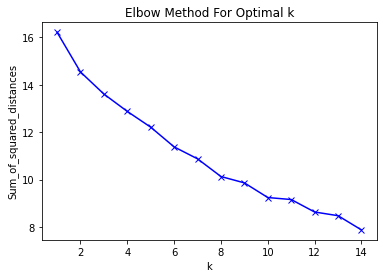

In [31]:
#determine optimal k for k-means clustering
import matplotlib.pyplot as plt
delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(delhi_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [32]:
# set number of clusters
kclusters = 5

#delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the data frame
kmeans.labels_[0:10]

array([0, 0, 0, 2, 2, 1, 2, 0, 3, 0], dtype=int32)

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = nhoods

# merge delhi_grouped with nhoods to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

delhi_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,28.614193,77.071541,0.0,Pool,Indian Restaurant,Gym,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
1,Ashok Vihar,28.699453,77.184826,2.0,Pizza Place,Fast Food Restaurant,Indian Restaurant,South Indian Restaurant,Donut Shop,Asian Restaurant,Snack Place,Coffee Shop,Sandwich Place,Fried Chicken Joint
2,Begum Pur,28.725503,77.058371,3.0,Business Service,Yoga Studio,Dessert Shop,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
3,Karala,28.732003,77.031827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Model Town,28.702714,77.193991,2.0,Pizza Place,Department Store,Light Rail Station,Frozen Yogurt Shop,Food Truck,Coffee Shop,Fast Food Restaurant,Bakery,Snack Place,Donut Shop


In [34]:
#clean the dataframe delhi_merged
delhi_merged.dropna(subset = ["Cluster Labels"], inplace = True)
delhi_merged.reset_index(drop = True, inplace = True)
delhi_merged['Cluster Labels']=delhi_merged['Cluster Labels'].fillna(0).astype(int) #change cluster labels from float to int
delhi_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,28.614193,77.071541,0,Pool,Indian Restaurant,Gym,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
1,Ashok Vihar,28.699453,77.184826,2,Pizza Place,Fast Food Restaurant,Indian Restaurant,South Indian Restaurant,Donut Shop,Asian Restaurant,Snack Place,Coffee Shop,Sandwich Place,Fried Chicken Joint
2,Begum Pur,28.725503,77.058371,3,Business Service,Yoga Studio,Dessert Shop,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
3,Model Town,28.702714,77.193991,2,Pizza Place,Department Store,Light Rail Station,Frozen Yogurt Shop,Food Truck,Coffee Shop,Fast Food Restaurant,Bakery,Snack Place,Donut Shop
4,Narela,28.842610,77.091835,2,Men's Store,Electronics Store,Yoga Studio,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


Let us now map the clusters of Delhi.

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + '/ Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,
        fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining the clusters

#### Cluster 0

In [36]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Pool,Indian Restaurant,Gym,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
5,Pitam Pura,Indian Restaurant,Pizza Place,Snack Place,Bus Station,Park,Light Rail Station,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck
6,Shalimar Bagh,Spa,Indian Restaurant,Mobile Phone Shop,Shipping Store,Restaurant,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck
7,Civil Lines,Light Rail Station,Flea Market,Italian Restaurant,Indian Restaurant,Lake,Hotel,Chinese Restaurant,Coffee Shop,Yoga Studio,Frozen Yogurt Shop
11,Kotwali,Indian Restaurant,Hotel,Snack Place,Restaurant,Market,Dessert Shop,Hostel,Pizza Place,Historic Site,Food & Drink Shop
19,Wazirabad,Beer Garden,Thai Restaurant,Indian Restaurant,Pizza Place,Park,Snack Place,Arcade,Asian Restaurant,Flea Market,Chinese Restaurant
20,Dilshad Garden,Pizza Place,Diner,Indian Restaurant,Shop & Service,Light Rail Station,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
26,Chandni Chowk,Indian Restaurant,Snack Place,Dessert Shop,Fast Food Restaurant,Market,Hardware Store,Paper / Office Supplies Store,Restaurant,Flea Market,Museum
27,Daryaganj,Indian Restaurant,Hotel,Hostel,Road,Soccer Stadium,History Museum,Movie Theater,Cricket Ground,Flea Market,Food Truck
28,Jhandewalan,Indian Restaurant,Snack Place,Pizza Place,Light Rail Station,Burrito Place,Food & Drink Shop,Bed & Breakfast,BBQ Joint,Gift Shop,Fast Food Restaurant


#### Cluster 1

In [37]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Gulabi Bagh,Train Station,Park,Mobile Phone Shop,Light Rail Station,Mini Golf,Yoga Studio,Flea Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
14,Sarai Rohilla,Shopping Mall,Gym,Train Station,Light Rail Station,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
16,Shastri Nagar.,Pizza Place,Train Station,Light Rail Station,Hotel,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
17,Tis Hazari,Multicuisine Indian Restaurant,Light Rail Station,Food Truck,Yoga Studio,Flea Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court
43,Pandav Nagar,Movie Theater,Shopping Mall,Moving Target,Hotel,Train Station,Light Rail Station,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant
60,Jor Bagh,ATM,Train Station,Light Rail Station,Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
84,Badarpur,ATM,Construction & Landscaping,Train Station,Light Rail Station,Liquor Store,Health & Beauty Service,Flea Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
90,Moti Bagh,Pizza Place,Shopping Mall,Light Rail Station,Hotel,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
104,Patel Nagar,Women's Store,Indian Restaurant,Moving Target,Café,Train Station,Light Rail Station,Yoga Studio,Flea Market,Frozen Yogurt Shop,Fried Chicken Joint


#### Cluster 2

In [38]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 2, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ashok Vihar,Pizza Place,Fast Food Restaurant,Indian Restaurant,South Indian Restaurant,Donut Shop,Asian Restaurant,Snack Place,Coffee Shop,Sandwich Place,Fried Chicken Joint
3,Model Town,Pizza Place,Department Store,Light Rail Station,Frozen Yogurt Shop,Food Truck,Coffee Shop,Fast Food Restaurant,Bakery,Snack Place,Donut Shop
4,Narela,Men's Store,Electronics Store,Yoga Studio,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
9,Kamla Nagar,Breakfast Spot,Fast Food Restaurant,Pizza Place,Indian Restaurant,Chinese Restaurant,Donut Shop,Dumpling Restaurant,Coffee Shop,Café,Flea Market
10,Kashmiri Gate,Pizza Place,Light Rail Station,Café,Boutique,Flea Market,Historic Site,Fast Food Restaurant,Hotel,Bus Station,Lake
12,Mori Gate,Fast Food Restaurant,Dessert Shop,Light Rail Station,Snack Place,Pizza Place,Food & Drink Shop,Bus Station,Boutique,Miscellaneous Shop,Historic Site
13,Sadar Bazaar,Liquor Store,Farm,Yoga Studio,Flea Market,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
15,Shakti Nagar,Breakfast Spot,Flea Market,Coffee Shop,Miscellaneous Shop,Snack Place,Restaurant,Electronics Store,Parking,Donut Shop,Playground
18,Timarpur,Café,Asian Restaurant,Pizza Place,Coffee Shop,Tibetan Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
25,Yamuna Vihar,Mobile Phone Shop,ATM,Pizza Place,Flea Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


#### Cluster 3

In [39]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 3, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Begum Pur,Business Service,Yoga Studio,Dessert Shop,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court


#### Cluster 4

In [40]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 4, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Naveen Shahdara,ATM,Light Rail Station,Park,Chocolate Shop,Shipping Store,Platform,Vegetarian / Vegan Restaurant,IT Services,Farm,Food Truck
22,New Usmanpur,IT Services,Yoga Studio,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
23,Shahdara,ATM,Platform,Vegetarian / Vegan Restaurant,Mobile Phone Shop,Light Rail Station,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
24,Shastri Park,ATM,IT Services,Business Service,Fast Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Dog Run,Fried Chicken Joint
76,Sangam Vihar,ATM,Athletics & Sports,Flea Market,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
92,Najafgarh,ATM,IT Services,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
94,Palam,ATM,Clothing Store,Department Store,Airport,Food,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint


In [41]:
delhi_results = pd.DataFrame(kmeans.cluster_centers_)
delhi_results.columns = delhi_grouped_clustering.columns
delhi_results.index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4']
delhi_results['Total Sum'] = delhi_results.sum(axis = 1)
delhi_results

,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Karnataka Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Total Sum
Cluster 0,0.001479,6.009615e-04,2.136752e-03,0.002912,3.338675e-03,1.385277e-02,0.001948,0.023848,6.890240e-03,4.370629e-04,1.500219e-02,8.913958e-04,0.010497,0.000437,0.013331,2.661401e-03,3.402206e-03,0.000726,1.923077e-03,2.036361e-03,-2.981556e-19,0.000601,5.441934e-03,4.091653e-04,2.357654e-03,2.003205e-04,0.001374,0.002137,-1.040834e-17,8.673617e-19,4.893287e-02,-3.469447e-18,0.019986,1.301043e-18,0.004293,5.216830e-03,0.041726,-2.981556e-19,8.361204e-04,8.456083e-04,0.000427,5.197505e-04,6.505213e-19,0.003258,4.265649e-04,1.282051e-03,2.563221e-03,9.742170e-03,0.010622,0.007610,5.494505e-04,7.916434e-03,0.000601,9.615385e-04,6.528092e-04,1.914209e-03,4.696718e-04,8.673617e-18,4.336809e-19,0.030233,1.577439e-02,3.646635e-03,4.188306e-03,0.004201,0.001949,4.080701e-03,1.479290e-03,0.000447,0.000641,4.314938e-03,0.000836,0.001210,1.373626e-03,2.945424e-03,6.505213e-19,5.494505e-04,0.000200,1.264494e-02,5.814329e-03,1.221309e-03,6.505213e-19,4.356036e-03,2.243590e-03,8.673617e-19,4.541245e-03,1.067575e-03,6.702876e-02,2.515135e-03,1.387779e-17,3.914674e-03,2.787068e-04,1.655607e-01,0.001479,1.720167e-03,1.372572e-02,0.006293,1.525918e-03,9.455128e-03,1.719734e-03,8.361204e-04,4.832895e-04,2.136752e-03,0.01

### Visualizing top 10 venues for each cluster

In [53]:
from matplotlib.patches import Patch

def generate_plot(clus, i):
        
    plt.style.use('default')

    tags=['Restaurant','Coffee','Food','Pizza','Sandwich', 'Hotel']
    colors = []
    for value in clus.index: 
        if any(t in value for t in tags):
            colors.append('#32069f')
        else:
            colors.append('#a80000')

    ax=clus.plot(kind='barh', figsize=(16,8), color=colors, alpha=0.7)

    plt.title('(in % of all venues)\n')
    ax.title.set_fontsize(14)
    plt.suptitle('Ten Most Prevalent Venues of Cluster {}'.format(i), fontsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.xticks([])
    ax.tick_params(axis ='both', which ='both', length = 0)
    labels = [(item.get_text()+'  ') for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)

    for label in (ax.get_yticklabels()):
        label.set_fontsize(12)

    for index, value in enumerate(clus): 
        label = "%.1f " % round(value*100,1) + "%"
        # place text at the end of bar (adding 0.001 to x, and 0.1 from y to make it appear just after the bar)
        plt.annotate(label, xy=(value + 0.001, index - 0.1), color='black',fontsize=12)

    legend_elements = [Patch(facecolor='#32069f', edgecolor='#32069f',
                             label='Food Venues',alpha=0.7),
                       Patch(facecolor='#a80000', edgecolor='#a80000',
                             label='Others',alpha=0.7)]

    ax.legend(handles=legend_elements, loc='best',fontsize=12)
    plt.show()

#### Cluster 0

In [54]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


,Indian Restaurant,Hotel,Café,Coffee Shop,Pizza Place,Fast Food Restaurant,Restaurant,Snack Place,Asian Restaurant,Market,Chinese Restaurant,Light Rail Station,Flea Market,Sandwich Place,BBQ Joint,Arcade,Italian Restaurant,Bar,Gym,Train Station,Park,Dessert Shop,Bakery,Pool,Department Store,Spa,Juice Bar,Lounge,Shopping Mall,Donut Shop,Diner,Multiplex,Nightclub,Plaza,Athletics & Sports,Shop & Service,Japanese Restaurant,Gym / Fitness Center,Breakfast Spot,Cocktail Bar,Hostel,Historic Site,Garden,Clothing Store,Food Court,Food & Drink Shop,French Restaurant,Mediterranean Restaurant,Ice Cream Shop,Thai Restaurant,Pharmacy,Trail,Food,Beer Garden,Stadium,Antique Shop,Vegetarian / Vegan Restaurant,Convenience Store,Shipping Store,Mobile Phone Shop,Women's Store,Golf Course,American Restaurant,Playground,Bed & Breakfast,Deli / Bodega,Hotel Bar,Burger Joint,Pub,History Museum,Road,Bus Station,Lake,Airport,Tea Room,Bistro,Temple,Food Truck,Art Gallery,Big Box Store,Track,Event Space,South Indian Restaurant,Theater,Liquor Store,Multicuisine Indian Restaurant,Indie Movie Theater,Karaoke Bar,Movie Theater,Miscellaneous Shop,Jazz Club,ATM,Indian Sweet Shop,Soup Place,Fried Chicken Joint,Gift Shop,Burrito Place,Monument / Landmark,Wings Joint,Soccer Stadium,Cricket Ground,Moving Target,Hardware Store,Paper / Office Supplies Store,Gastropub,Tibetan Restaurant,Other Nightlife,Steakhouse,Hot Dog Joint,Mexican Restaurant,Salon / Barbershop,Modern European Restaurant,Eastern European Restaurant,Racetrack,Motel,Bagel Shop,Comedy Club,Record Shop,Garden Center,University,Outdoors & Recreation,College Gym,Salad Place,Vietnamese Restaurant,Moroccan Restaurant,Smoke Shop,Karnataka Restaurant,Performing Arts Venue,Molecular Gastronomy Restaurant,Portuguese Restaurant,Bengali Restaurant,Mughlai Restaurant,Motorcycle Shop,Electronics Store,Furniture / Home Store,Dumpling Restaurant,Shoe Store,Boutique,Accessories Store,Punjabi Restaurant,Museum,Mosque,Northeast Indian Restaurant,Seafood Restaurant,Greek Restaurant,Dog Run,Platform,Concert Hall,Korean Restaurant,Falafel Restaurant,Tapas Restaurant,Scandinavian Restaurant,Turkish Restaurant,Frozen Yogurt Shop,Australian Restaurant,Other Great Outdoors,Bank,Music Venue,Toy / Game Store,Tex-Mex Restaurant,Cosmetics Shop,Comfort Food Restaurant,Bridal Shop,Indian Chinese Restaurant,North Indian Restaurant,Middle Eastern Restaurant,Grocery Store,Burmese Restaurant,IT Services,Farm,Music Store,Chocolate Shop,Hookah Bar,Cafeteria,Sports Bar,Health & Beauty Service,Gourmet Shop,Construction & Landscaping,Parking,Mini Golf,Nightlife Spot,Farmers Market,Whisky Bar,Men's Store,Spanish Restaurant,Speakeasy,Bookstore,College Cafeteria,Yoga Studio,Sculpture Garden,Mattress Store,Castle,Business Service
Cluster 0,0.165561,0.067029,0.048933,0.041726,0.031255,0.030233,0.028742,0.025386,0.023848,0.020824,0.019986,0.017439,0.015774,0.015534,0.015002,0.013853,0.013726,0.013331,0.012645,0.012131,0.012034,0.010622,0.010497,0.009773,0.009742,0.00955,0.009455,0.009073,0.00812,0.007916,0.00761,0.007275,0.006963,0.00692,0.00689,0.006481,0.006293,0.005814,0.005442,0.005217,0.004541,0.004356,0.004315,0.004293,0.004201,0.004188,0.004081,0.003925,0.003915,0.003876,0.003846,0.003846,0.003647,0.003402,0.003392,0.003339,0.003277,0.003258,0.003205,0.003205,0.003079,0.002945,0.002912,0.002747,0.002661,0.002563,0.002515,0.002358,0.002342,0.002244,0.002162,0.002137,0.002137,0.002137,0.002098,0.002036,0.002029,0.001949,0.001948,0.001923,0.001923,0.001914,0.00187,0.001764,0.001748,0.001723,0.00172,0.00172,0.001691,0.001657,0.001526,0.001479,0.001479,0.001479,0.001479,0.001374,0.001374,0.001313,0.001282,0.001282,0.001282,0.001282,0.001221,0.001221,0.00121,0.00117,0.001095,0.00109,0.001068,0.001004,0.000968,0.000962,0.000962,0.000962,0.000899,0.000891,0.000846,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000763,0.000763,0.000763,0.000726,0.000712,0.000687,0.000653,0.000641,0.000601,0.000601,0.0006

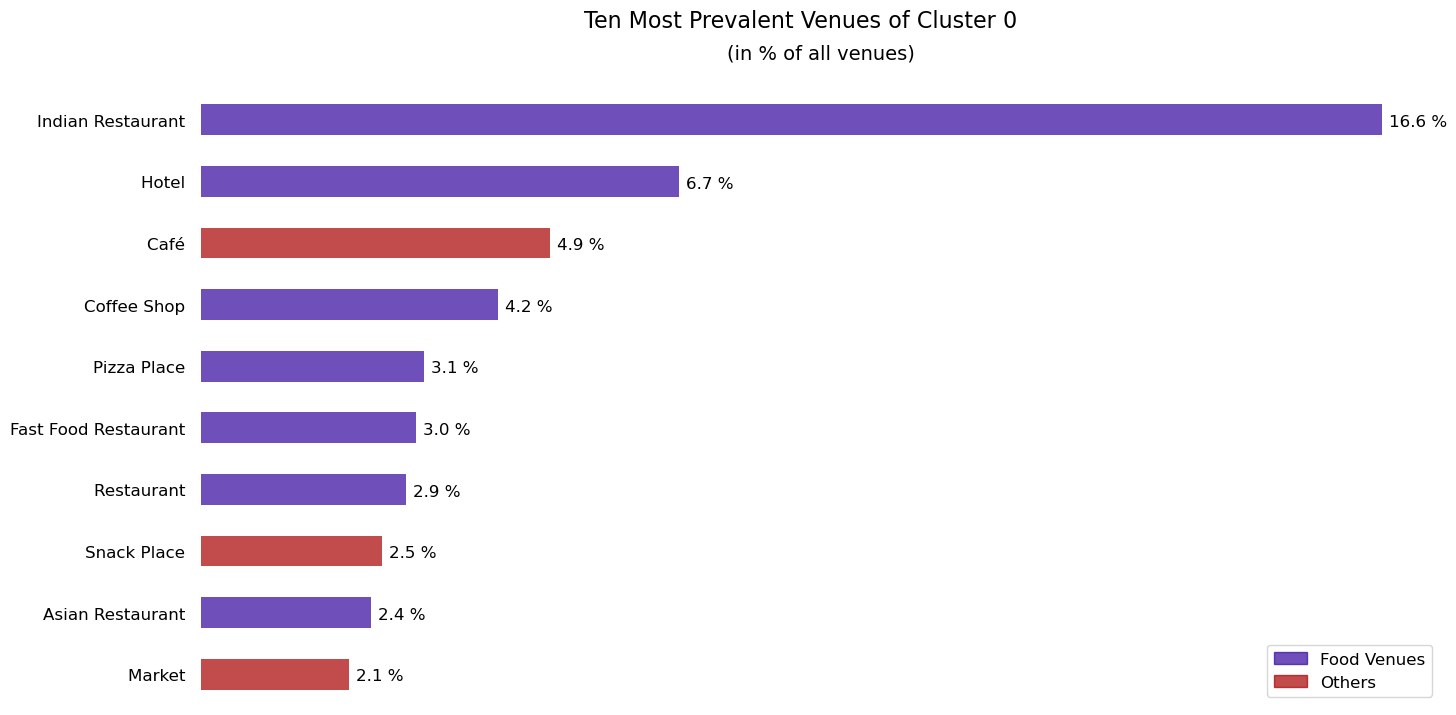

In [55]:
import matplotlib.pyplot as plt
cluster0=pd.DataFrame(delhi_results.iloc[0,0:-1]).transpose()
cluster0.sort_values(by='Cluster 0',axis=1,ascending=False,inplace=True)
display(cluster0)

clus0=cluster0.iloc[0,9::-1]
generate_plot(clus0,0)

#### Cluster 1

,Light Rail Station,Train Station,Shopping Mall,Hotel,Pizza Place,ATM,Multicuisine Indian Restaurant,Moving Target,Food Truck,Gym,Restaurant,Construction & Landscaping,Mini Golf,Health & Beauty Service,Mobile Phone Shop,Park,Movie Theater,Indian Restaurant,Café,Women's Store,Liquor Store,Sandwich Place,Spa,BBQ Joint,IT Services,Flea Market,Breakfast Spot,Fried Chicken Joint,Arcade,Playground,Gym / Fitness Center,Shipping Store,Food & Drink Shop,Cocktail Bar,Beer Garden,Hotel Bar,Event Space,French Restaurant,North Indian Restaurant,Antique Shop,Salad Place,Smoke Shop,Performing Arts Venue,University,Vietnamese Restaurant,Karnataka Restaurant,Outdoors & Recreation,Steakhouse,College Gym,Moroccan Restaurant,Cosmetics Shop,Record Shop,Salon / Barbershop,Mughlai Restaurant,Concert Hall,Multiplex,Motel,Mattress Store,Motorcycle Shop,Mediterranean Restaurant,Men's Store,Miscellaneous Shop,Music Store,Mosque,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Museum,Plaza,Music Venue,Nightlife Spot,Whisky Bar,Trail,Track,Toy / Game Store,Theater,Thai Restaurant,Tex-Mex Restaurant,Temple,Tea Room,Stadium,Sports Bar,Speakeasy,South Indian Restaurant,Soccer Stadium,Snack Place,Shop & Service,Shoe Store,Road,Racetrack,Punjabi Restaurant,Pub,Portuguese Restaurant,Platform,Pharmacy,Parking,Other Nightlife,Other Great Outdoors,Lake,Yoga Studio,Dessert Shop,Deli / Bodega,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Bistro,Dog Run,Diner,Bookstore,Boutique,Bridal Shop,Cricket Ground,Food Court,Convenience Store,Comfort Food Restaurant,Comedy Club,College Cafeteria,Coffee Shop,Clothing Store,Chocolate Shop,Chinese Restaurant,Castle,Cafeteria,Business Service,Bus Station,Burrito Place,Burmese Restaurant,Big Box Store,Hostel,History Museum,Airport,Accessories Store,American Restaurant,Art Gallery,Japanese Restaurant,Italian Restaurant,Indie Movie Theater,Asian Restaurant,Indian Sweet Shop,Indian Chinese Restaurant,Frozen Yogurt Shop,Bagel Shop,Burger Joint,Historic Site,Bar,Grocery Store,Bengali Restaurant,Greek Restaurant,Gourmet Shop,Bank,Furniture / Home Store,Bakery,Gift Shop,Gastropub,Garden Center,Turkish Restaurant,Scandinavian Restaurant,Tapas Restaurant,Spanish Restaurant,Seafood Restaurant,Mexican Restaurant,Northeast Indian Restaurant,Australian Restaurant,Korean Restaurant,Jazz Club,Hot Dog Joint,Paper / Office Supplies Store,Hardware Store,Bed & Breakfast,Wings Joint,Middle Eastern Restaurant,Hookah Bar,Sculpture Garden,Soup Place,Karaoke Bar,Tibetan Restaurant,Garden,Golf Course,Nightclub,Food,Athletics & Sports,Ice Cream Shop,Vegetarian / Vegan Restaurant,Lounge,Juice Bar,Donut Shop,Pool,Department Store,Market
Cluster 1,0.222222,0.175926,0.074074,0.074074,0.055556,0.046296,0.037037,0.037037,0.037037,0.027778,0.027778,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,3.469447e-18,1.734723e-18,1.734723e-18,1.734723e-18,1.734723e-18,8.673617e-19,8.673617e-19,8.673617e-19,4.336809e-19,4.336809e-19,4.336809e-19,4.336809e-19,4.336809e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,5.421011e-20,5.421011e-20,2.710505e-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.710505e-20,-2.710505e-20,-2.710505e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-1.084202e-19,-1.084202e-19,-1.084202e-19,-1.084202e-19,-1.084202e-19,-1.084202e-19

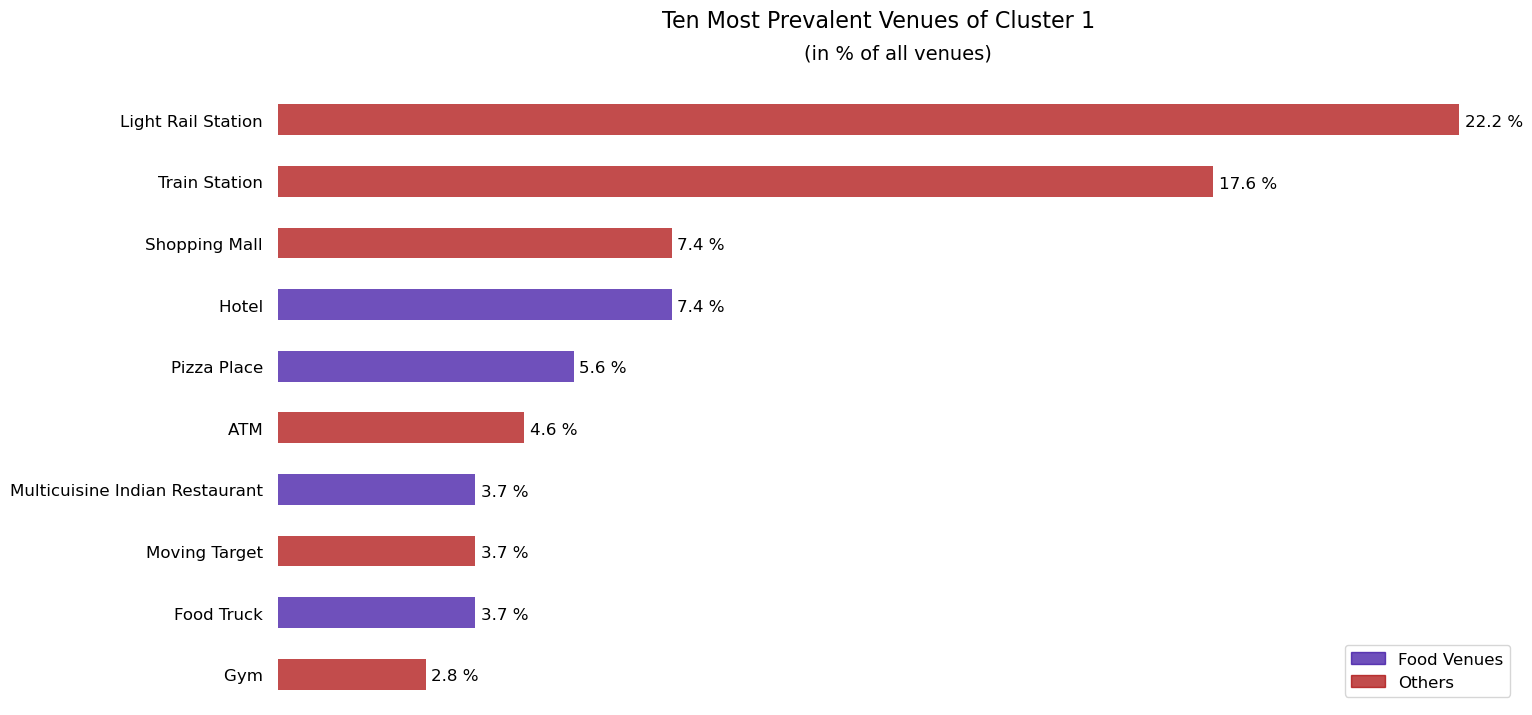

In [56]:
cluster1=pd.DataFrame(delhi_results.iloc[1,0:-1]).transpose()
cluster1.sort_values(by='Cluster 1',axis=1,ascending=False,inplace=True)
display(cluster1)

clus1=cluster1.iloc[0,9::-1]
generate_plot(clus1,1)

#### Cluster 2

,Fast Food Restaurant,Pizza Place,Café,Coffee Shop,Indian Restaurant,Shopping Mall,Historic Site,Market,Donut Shop,Sandwich Place,Chinese Restaurant,Restaurant,Electronics Store,Farm,Mobile Phone Shop,Park,Pool,Light Rail Station,Bakery,Men's Store,Gym,Clothing Store,Department Store,Asian Restaurant,Liquor Store,Castle,Snack Place,Fried Chicken Joint,Movie Theater,Italian Restaurant,Hotel,Spa,Stadium,Flea Market,Bar,Dessert Shop,Music Store,Business Service,Ice Cream Shop,Breakfast Spot,Train Station,Multiplex,Food Court,Grocery Store,ATM,Mattress Store,South Indian Restaurant,Thai Restaurant,Japanese Restaurant,Lounge,Boutique,Furniture / Home Store,IT Services,Cafeteria,Theater,American Restaurant,Sports Bar,Moving Target,Vegetarian / Vegan Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Convenience Store,Tibetan Restaurant,Bus Station,Plaza,Gourmet Shop,Sculpture Garden,Juice Bar,Gift Shop,Wings Joint,Karaoke Bar,BBQ Joint,Indian Sweet Shop,Food & Drink Shop,Hookah Bar,Frozen Yogurt Shop,North Indian Restaurant,Playground,Parking,Farmers Market,Other Great Outdoors,Arcade,Music Venue,Food Truck,Lake,Pub,Soup Place,Garden Center,Comfort Food Restaurant,Gym / Fitness Center,Dumpling Restaurant,Performing Arts Venue,Monument / Landmark,Art Gallery,Whisky Bar,Nightclub,Mediterranean Restaurant,Shop & Service,Yoga Studio,Comedy Club,Golf Course,Diner,Bridal Shop,Cocktail Bar,Nightlife Spot,Spanish Restaurant,Cosmetics Shop,Tea Room,Pharmacy,Speakeasy,College Cafeteria,Bookstore,Temple,Gastropub,Bengali Restaurant,Steakhouse,Bank,Food,Garden,Athletics & Sports,Australian Restaurant,Korean Restaurant,Women's Store,Multicuisine Indian Restaurant,Deli / Bodega,Chocolate Shop,Airport,History Museum,Beer Garden,Road,Hotel Bar,Hardware Store,Shipping Store,Paper / Office Supplies Store,Hot Dog Joint,Salon / Barbershop,Greek Restaurant,Dog Run,Event Space,Cricket Ground,Mexican Restaurant,Soccer Stadium,French Restaurant,Mughlai Restaurant,Salad Place,Record Shop,Karnataka Restaurant,College Gym,Indie Movie Theater,Outdoors & Recreation,Smoke Shop,Moroccan Restaurant,University,Vietnamese Restaurant,Tex-Mex Restaurant,Bagel Shop,Toy / Game Store,Indian Chinese Restaurant,Track,Trail,Big Box Store,Antique Shop,Portuguese Restaurant,Modern European Restaurant,Motorcycle Shop,Eastern European Restaurant,Burrito Place,Racetrack,Other Nightlife,Molecular Gastronomy Restaurant,Platform,Turkish Restaurant,Falafel Restaurant,Burmese Restaurant,Tapas Restaurant,Scandinavian Restaurant,Concert Hall,Northeast Indian Restaurant,Seafood Restaurant,Motel,Punjabi Restaurant,Accessories Store,Museum,Shoe Store,Mosque,Burger Joint,Mini Golf,Health & Beauty Service,Bed & Breakfast,Construction & Landscaping,Jazz Club,Hostel,Bistro
Cluster 2,0.081788,0.069786,0.061699,0.045793,0.036596,0.025933,0.023705,0.022882,0.022388,0.020518,0.020378,0.019671,0.019359,0.017857,0.016667,0.015834,0.015476,0.015404,0.014575,0.014286,0.01412,0.01399,0.013476,0.013376,0.011905,0.011905,0.011169,0.010396,0.010189,0.009709,0.009504,0.009158,0.009062,0.008474,0.008402,0.008125,0.007937,0.007937,0.007934,0.007565,0.007256,0.006985,0.006231,0.006042,0.005952,0.005952,0.005834,0.005644,0.005097,0.004927,0.004825,0.004765,0.004762,0.004762,0.004657,0.004153,0.003968,0.003968,0.003864,0.003775,0.00373,0.003526,0.003401,0.003237,0.003096,0.003071,0.003066,0.002976,0.002976,0.002976,0.002883,0.002679,0.002653,0.002624,0.002616,0.002611,0.0026,0.002522,0.002522,0.002381,0.002251,0.002115,0.002078,0.001984,0.001984,0.001966,0.001832,0.001701,0.001701,0.001701,0.001642,0.001587,0.001587,0.001587,0.001587,0.001508,0.001488,0.001488,0.001488,0.001483,0.001483,0.001477,0.001401,0.001371,0.001371,0.000916,0.000916,0.000882,0.000882,0.000744,0.000627,0.000627,0.000627,0.000627,0.000627,0.000627,0.000627,0.000627,0.000595,0.000567,0.000567,0.000567,2.602085e-18,1.734723e-18,1.084202e-18,1.084202e-18,1.084202e-18,8.673617e-19,8.673617e-19,8.673617e-19,4.336809e-19,4.336809e-19,4.336

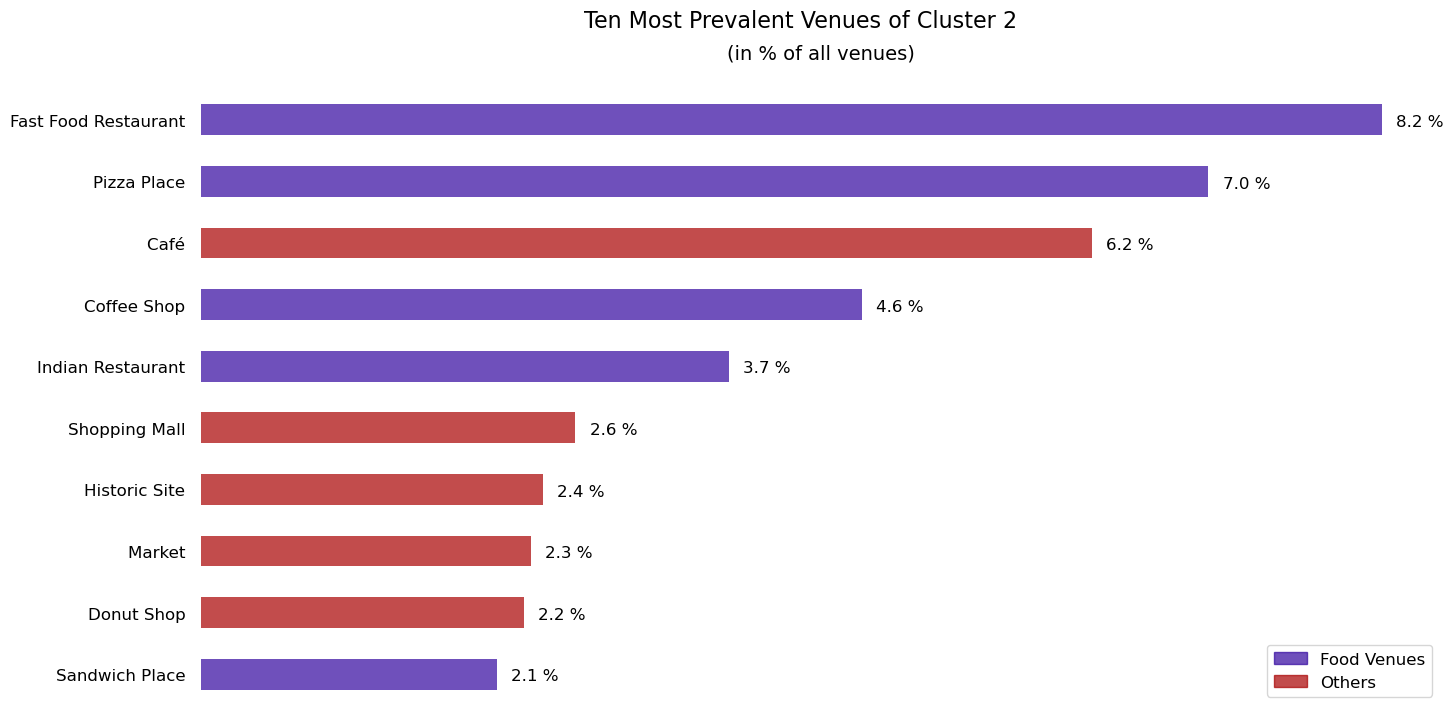

In [57]:
cluster2=pd.DataFrame(delhi_results.iloc[2,0:-1]).transpose()
cluster2.sort_values(by='Cluster 2',axis=1,ascending=False,inplace=True)
display(cluster2)

clus2=cluster2.iloc[0,9::-1]
generate_plot(clus2,2)

#### Cluster 3

,Business Service,ATM,Moving Target,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Nightclub,Nightlife Spot,North Indian Restaurant,Northeast Indian Restaurant,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Mughlai Restaurant,Movie Theater,Pool,Motorcycle Shop,Karnataka Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Plaza,Portuguese Restaurant,Juice Bar,Toy / Game Store,Stadium,Steakhouse,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Track,Speakeasy,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Sports Bar,Spanish Restaurant,Pub,Sculpture Garden,Punjabi Restaurant,Racetrack,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Spa,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South Indian Restaurant,Karaoke Bar,Jazz Club,Accessories Store,Coffee Shop,Burrito Place,Bus Station,Cafeteria,Café,Castle,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,College Cafeteria,Burger Joint,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Burmese Restaurant,Bridal Shop,Dessert Shop,Bagel Shop,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Breakfast Spot,Bank,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bistro,Bookstore,Boutique,Department Store,Diner,Japanese Restaurant,Hostel,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Golf Course,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Gourmet Shop,Gift Shop,Dog Run,Flea Market,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Food,Gastropub,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Yoga Studio
Cluster 3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


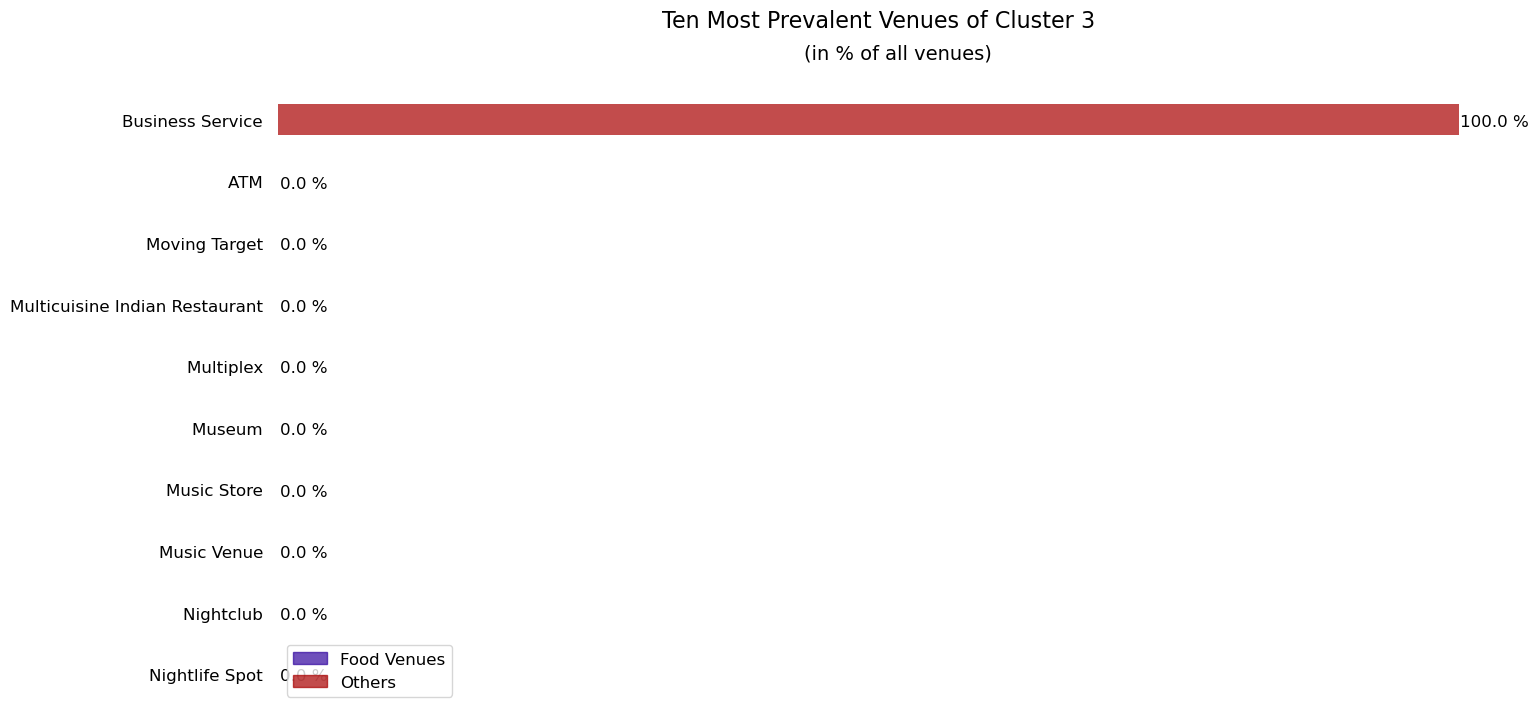

In [47]:
cluster3=pd.DataFrame(delhi_results.iloc[3,0:-1]).transpose()
cluster3.sort_values(by='Cluster 3',axis=1,ascending=False,inplace=True)
display(cluster3)

clus3=cluster3.iloc[0,9::-1]
generate_plot(clus3,3)

#### Cluster 4

,ATM,IT Services,Vegetarian / Vegan Restaurant,Light Rail Station,Platform,Athletics & Sports,Clothing Store,Department Store,Business Service,Fast Food Restaurant,Mobile Phone Shop,Shipping Store,Park,Chocolate Shop,Hotel,Café,Restaurant,Sandwich Place,Spa,Flea Market,Liquor Store,BBQ Joint,Electronics Store,Fried Chicken Joint,Breakfast Spot,Arcade,Movie Theater,Cocktail Bar,Food & Drink Shop,Gym / Fitness Center,Playground,Music Store,Health & Beauty Service,Event Space,Hotel Bar,Mini Golf,North Indian Restaurant,Construction & Landscaping,Antique Shop,Sports Bar,Beer Garden,Comedy Club,Vietnamese Restaurant,College Gym,Cosmetics Shop,Outdoors & Recreation,Salad Place,Smoke Shop,Bistro,Karnataka Restaurant,Record Shop,University,Performing Arts Venue,Steakhouse,Moroccan Restaurant,Mughlai Restaurant,Concert Hall,Burmese Restaurant,Multiplex,Tex-Mex Restaurant,Moving Target,Thai Restaurant,Theater,Mattress Store,Motorcycle Shop,Mediterranean Restaurant,Motel,Men's Store,Mosque,Miscellaneous Shop,Train Station,Molecular Gastronomy Restaurant,Tibetan Restaurant,Monument / Landmark,Toy / Game Store,Whisky Bar,Other Great Outdoors,Museum,Music Venue,Shoe Store,Shopping Mall,Salon / Barbershop,Road,Snack Place,Portuguese Restaurant,Plaza,Soccer Stadium,South Indian Restaurant,Speakeasy,Pizza Place,Stadium,Pharmacy,Parking,Tea Room,Other Nightlife,Temple,Nightlife Spot,Nightclub,Punjabi Restaurant,Yoga Studio,Dumpling Restaurant,Greek Restaurant,Boutique,Gastropub,Garden Center,Burger Joint,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Food Court,Burrito Place,Bus Station,Farm,Falafel Restaurant,Castle,Chinese Restaurant,Coffee Shop,College Cafeteria,Dog Run,Diner,Dessert Shop,Deli / Bodega,Cricket Ground,Convenience Store,Bookstore,Comfort Food Restaurant,Grocery Store,Bakery,Asian Restaurant,Accessories Store,Japanese Restaurant,Airport,Indie Movie Theater,Indian Sweet Shop,American Restaurant,Bagel Shop,Indian Chinese Restaurant,Hostel,Bank,History Museum,Bar,Bengali Restaurant,Art Gallery,Tapas Restaurant,Turkish Restaurant,Scandinavian Restaurant,Spanish Restaurant,Modern European Restaurant,Eastern European Restaurant,Northeast Indian Restaurant,Mexican Restaurant,Racetrack,Seafood Restaurant,Track,Australian Restaurant,Big Box Store,Bridal Shop,Korean Restaurant,Hardware Store,Farmers Market,Hot Dog Joint,Paper / Office Supplies Store,Jazz Club,Sculpture Garden,Cafeteria,Soup Place,Lake,Middle Eastern Restaurant,Pub,Trail,Gift Shop,Karaoke Bar,Gourmet Shop,Hookah Bar,Wings Joint,Bed & Breakfast,Shop & Service,Women's Store,Multicuisine Indian Restaurant,Golf Course,Garden,Food,Lounge,Ice Cream Shop,Juice Bar,Pool,Italian Restaurant,Donut Shop,Gym,Historic Site,Market,Indian Restaurant
Cluster 4,0.430272,0.214286,0.036281,0.036281,0.036281,0.035714,0.035714,0.035714,0.035714,0.035714,0.020408,0.015873,0.015873,0.015873,6.938894e-18,6.938894e-18,3.469447e-18,3.469447e-18,1.734723e-18,1.734723e-18,1.734723e-18,1.734723e-18,8.673617e-19,8.673617e-19,8.673617e-19,8.673617e-19,8.673617e-19,4.336809e-19,4.336809e-19,4.336809e-19,4.336809e-19,4.336809e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,2.168404e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,1.084202e-19,5.421011e-20,2.710505e-20,1.355253e-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.710505e-20,-2.710505e-20,-2.710505e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-5.421011e-20,-1.084202e-19,-1.084202e-19,-1.084202e-19,-1.0

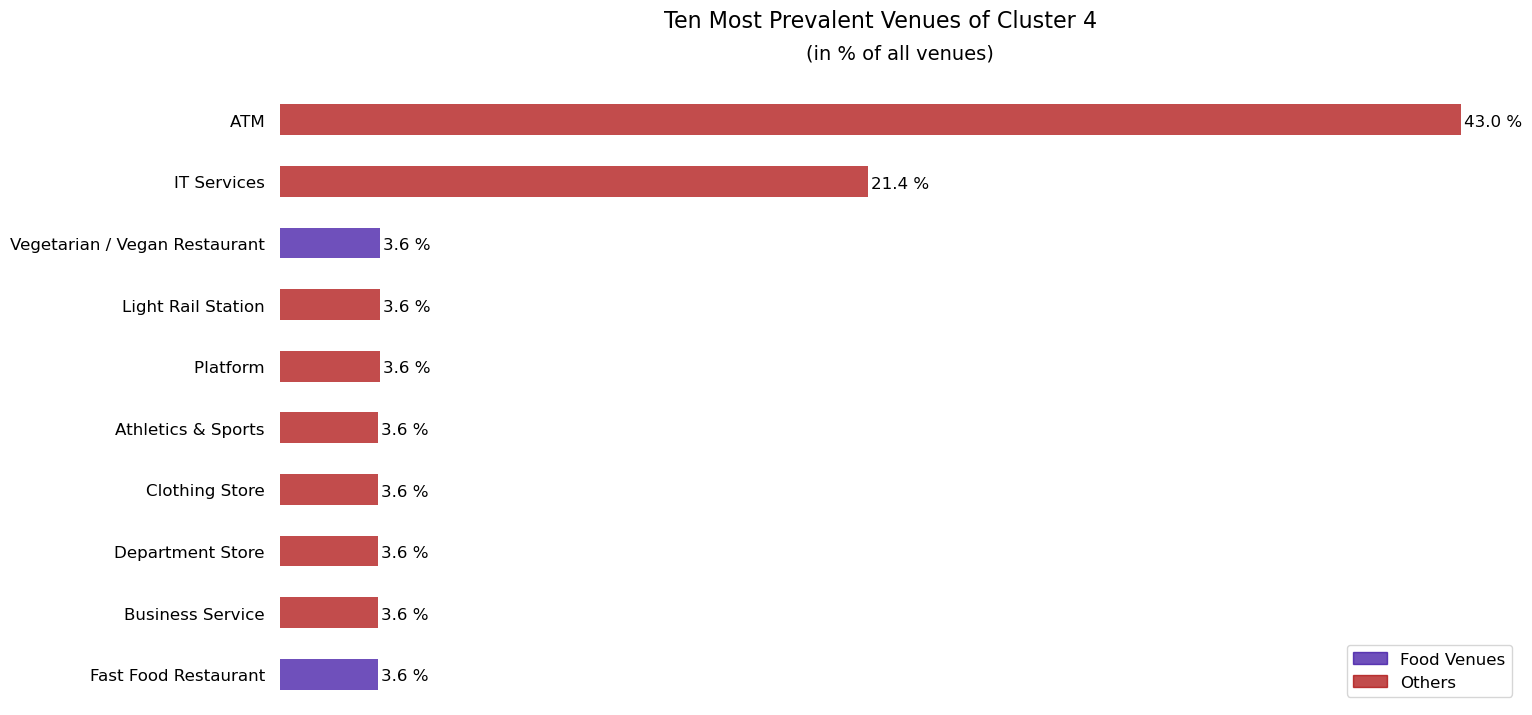

In [48]:
cluster4=pd.DataFrame(delhi_results.iloc[4,0:-1]).transpose()
cluster4.sort_values(by='Cluster 4',axis=1,ascending=False,inplace=True)
display(cluster4)

clus4=cluster4.iloc[0,9::-1]
generate_plot(clus4,4)

## Results and Discussion <a name="results"></a>

We observe that there are many restaurants of different cuisines in Cluster 0. So, let's check if Cluster 1 is OK. Well, it seems that we might have our task cut out here, but let's keep exploring. Just as in Cluster 0, we have heavy competition in Cluster 2, so let's skip this. Cluster 3 doesn't seem a good choice, obviously. Yes, even setting up a restaurant in Cluster 4 seems good.

So, the _competition is between cluster 1 and cluster 4_. How can we make a decision? If we had some data on the rent of properties in Delhi by neighborhoods, we could utilise them here, however, it's not available. If we analyse the neighborhoods in the two clusters, we observe that **places in cluster 1 are _more closer to the city center_ than those in cluster 4**.

Consequently, we have greater chances of more footfall here. So, we are now going to explore the neighborhoods in cluster 1.

In [58]:
cluster1nbhd=delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[0]].values.tolist()
cluster1nbhd

['Gulabi Bagh',
 'Sarai Rohilla',
 'Shastri Nagar.',
 'Tis Hazari',
 'Pandav Nagar',
 'Jor Bagh',
 'Badarpur',
 'Moti Bagh',
 'Patel Nagar']

In [59]:
filtered_nhoods=nhoods.copy()

for i in range(0,len(filtered_nhoods)):

    if filtered_nhoods.iloc[i,0] not in cluster1nbhd:
        filtered_nhoods.iloc[i,0]='TO DROP'

In [60]:
filtered_nhoods=filtered_nhoods[filtered_nhoods.Neighborhood!='TO DROP']
filtered_nhoods.reset_index(drop=True,inplace=True)
filtered_nhoods

,Neighborhood,Latitude,Longitude
0,Gulabi Bagh,28.669649,77.194726
1,Sarai Rohilla,28.667873,77.190267
2,Shastri Nagar.,28.670088,77.181859
3,Tis Hazari,28.667163,77.216631
4,Pandav Nagar,28.650024,77.153676
5,Jor Bagh,28.676608,77.158692
6,Badarpur,28.493170,77.303024
7,Moti Bagh,28.667619,77.184227
8,Patel Nagar,28.659809,77.156957


We have a dataframe having just the neighborhoods, and their geographical coordinates (latitude and longitude) belonging to cluster 1. So, now we take all the venues that are in these neighborhoods. And then let us explore all the Chinese restaurants that are in these areas.

In [61]:
hotel_venues = getNearbyVenues(names=filtered_nhoods['Neighborhood'], latitudes=filtered_nhoods['Latitude'], longitudes=filtered_nhoods['Longitude'])

hotel_venues = hotel_venues[hotel_venues['Venue_Category'].str.contains("Chinese")].reset_index(drop=True)
hotel_venues.head()

Gulabi Bagh
Sarai Rohilla
Shastri Nagar.
Tis Hazari
Pandav Nagar
Jor Bagh
Badarpur
Moti Bagh
Patel Nagar


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category


This really comes as a surprise to us that there are no Chinese restaurants in the neighborhood. One could really look for neighborhoods among Cluster 1 that offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics.

The final result of all this is **9 zones (_in Cluster 1_) containing largest number of potential new restaurant locations**. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! That's because it is entirely possible that there is a very good reason for no Chinese restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify areas in Delhi (one might add, closer to the city center) in order to aid stakeholders in narrowing down the search for optimal location for a new Chinese restaurant. By calculating restaurant density distribution from Foursquare data we first identified that neighborhoods in Cluster 1, some of which include: Badarpur, Gulabi Bagh, Jor Bagh, Patel Nagar, Shastri Nagar and Tis Hazari would be the ideal location to start a Chinese restaurant.

The final decisions on an optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.